In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_25.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_25.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_decoding = [entry['output'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_decoding = [entry['output'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement, non_infringement_decoding, infringement_decoding

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement, non_infringement_decoding, infringement_decoding = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


In [7]:


# def cut_text_by_remaining(text, remaining_length):
#     if remaining_length >= len(text):
#         return "" 
#     else:
#         return text[:-remaining_length]

# non_infringement_decoding = cut_text_by_remaining(non_infringement_decoding,10)
# infringement_decoding = cut_text_by_remaining(infringement_decoding,10)

In [8]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
X_non_infringement_decoding = extract_hidden_states(non_infringement_decoding, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, X_non_infringement_decoding, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
X_infringement_decoding = extract_hidden_states(infringement_decoding, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, X_infringement_decoding, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 220/220 [02:43<00:00,  1.35it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 220/220 [00:02<00:00, 93.48it/s] 


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 200/200 [00:01<00:00, 105.86it/s]


In [9]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epochs:   0%|          | 12/2500 [00:00<02:14, 18.44it/s]

Epoch 10/2500, Loss: 0.3279
Test Accuracy at Epoch 10: 71.43%
Test F1-score at Epoch 10: 0.7681
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.83      0.51      0.63       160
non_infringement       0.67      0.90      0.77       176

        accuracy                           0.71       336
       macro avg       0.75      0.70      0.70       336
    weighted avg       0.74      0.71      0.70       336

New best model saved with F1-score 0.7681 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.83      0.51      0.63       160
non_infringement       0.67      0.90      0.77       176

        accuracy                           0.71       336
       macro avg       0.75      0.70      0.70       336
    weighted avg       0.74      0.71      0.70       336



Training Epochs:   1%|          | 21/2500 [00:01<02:38, 15.68it/s]

Epoch 20/2500, Loss: 0.1141
Test Accuracy at Epoch 20: 71.43%
Test F1-score at Epoch 20: 0.7303
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       160
non_infringement       0.72      0.74      0.73       176

        accuracy                           0.71       336
       macro avg       0.71      0.71      0.71       336
    weighted avg       0.71      0.71      0.71       336



Training Epochs:   1%|          | 31/2500 [00:01<02:44, 15.05it/s]

Epoch 30/2500, Loss: 0.0732
Test Accuracy at Epoch 30: 71.73%
Test F1-score at Epoch 30: 0.7493
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.74      0.62      0.68       160
non_infringement       0.70      0.81      0.75       176

        accuracy                           0.72       336
       macro avg       0.72      0.71      0.71       336
    weighted avg       0.72      0.72      0.71       336



Training Epochs:   2%|▏         | 41/2500 [00:02<03:19, 12.35it/s]

Epoch 40/2500, Loss: 0.0335
Test Accuracy at Epoch 40: 73.51%
Test F1-score at Epoch 40: 0.7735
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       160
non_infringement       0.70      0.86      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.75      0.74      0.73       336

New best model saved with F1-score 0.7735 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       160
non_infringement       0.70      0.86      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.75      0.74      0.73       336



Training Epochs:   2%|▏         | 51/2500 [00:03<02:58, 13.69it/s]

Epoch 50/2500, Loss: 0.0162
Test Accuracy at Epoch 50: 73.51%
Test F1-score at Epoch 50: 0.7747
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       160
non_infringement       0.70      0.87      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.75      0.74      0.73       336

New best model saved with F1-score 0.7747 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       160
non_infringement       0.70      0.87      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.75      0.74      0.73       336



Training Epochs:   2%|▏         | 62/2500 [00:04<02:45, 14.69it/s]

Epoch 60/2500, Loss: 0.0097
Test Accuracy at Epoch 60: 73.21%
Test F1-score at Epoch 60: 0.7739
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.81      0.57      0.67       160
non_infringement       0.69      0.88      0.77       176

        accuracy                           0.73       336
       macro avg       0.75      0.72      0.72       336
    weighted avg       0.75      0.73      0.73       336



Training Epochs:   3%|▎         | 72/2500 [00:04<02:28, 16.39it/s]

Epoch 70/2500, Loss: 0.0066
Test Accuracy at Epoch 70: 73.21%
Test F1-score at Epoch 70: 0.7739
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.81      0.57      0.67       160
non_infringement       0.69      0.88      0.77       176

        accuracy                           0.73       336
       macro avg       0.75      0.72      0.72       336
    weighted avg       0.75      0.73      0.73       336



Training Epochs:   3%|▎         | 80/2500 [00:05<03:35, 11.24it/s]

Epoch 80/2500, Loss: 0.0050
Test Accuracy at Epoch 80: 72.32%
Test F1-score at Epoch 80: 0.7657
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.79      0.57      0.66       160
non_infringement       0.69      0.86      0.77       176

        accuracy                           0.72       336
       macro avg       0.74      0.72      0.71       336
    weighted avg       0.74      0.72      0.72       336



Training Epochs:   4%|▎         | 90/2500 [00:06<02:58, 13.50it/s]

Epoch 90/2500, Loss: 0.0041
Test Accuracy at Epoch 90: 72.02%
Test F1-score at Epoch 90: 0.7626
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.86      0.76       176

        accuracy                           0.72       336
       macro avg       0.74      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   4%|▍         | 101/2500 [00:06<02:40, 14.92it/s]

Epoch 100/2500, Loss: 0.0034
Test Accuracy at Epoch 100: 72.02%
Test F1-score at Epoch 100: 0.7626
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.86      0.76       176

        accuracy                           0.72       336
       macro avg       0.74      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   4%|▍         | 111/2500 [00:07<02:53, 13.79it/s]

Epoch 110/2500, Loss: 0.0030
Test Accuracy at Epoch 110: 72.02%
Test F1-score at Epoch 110: 0.7626
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.86      0.76       176

        accuracy                           0.72       336
       macro avg       0.74      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   5%|▍         | 122/2500 [00:08<02:46, 14.28it/s]

Epoch 120/2500, Loss: 0.0026
Test Accuracy at Epoch 120: 72.02%
Test F1-score at Epoch 120: 0.7614
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   5%|▌         | 134/2500 [00:09<02:01, 19.51it/s]

Epoch 130/2500, Loss: 0.0024
Test Accuracy at Epoch 130: 72.02%
Test F1-score at Epoch 130: 0.7614
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   6%|▌         | 144/2500 [00:09<01:35, 24.72it/s]

Epoch 140/2500, Loss: 0.0021
Test Accuracy at Epoch 140: 72.02%
Test F1-score at Epoch 140: 0.7614
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   6%|▌         | 154/2500 [00:09<01:31, 25.62it/s]

Epoch 150/2500, Loss: 0.0019
Test Accuracy at Epoch 150: 72.02%
Test F1-score at Epoch 150: 0.7614
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   7%|▋         | 165/2500 [00:10<01:26, 27.08it/s]

Epoch 160/2500, Loss: 0.0017
Test Accuracy at Epoch 160: 72.02%
Test F1-score at Epoch 160: 0.7614
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   7%|▋         | 175/2500 [00:10<01:29, 25.95it/s]

Epoch 170/2500, Loss: 0.0015
Test Accuracy at Epoch 170: 72.02%
Test F1-score at Epoch 170: 0.7614
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   7%|▋         | 185/2500 [00:10<01:28, 26.09it/s]

Epoch 180/2500, Loss: 0.0014
Test Accuracy at Epoch 180: 72.02%
Test F1-score at Epoch 180: 0.7614
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   8%|▊         | 191/2500 [00:11<01:51, 20.72it/s]

Epoch 190/2500, Loss: 0.0012
Test Accuracy at Epoch 190: 72.02%
Test F1-score at Epoch 190: 0.7614
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   8%|▊         | 204/2500 [00:11<01:30, 25.25it/s]

Epoch 200/2500, Loss: 0.0011
Test Accuracy at Epoch 200: 72.02%
Test F1-score at Epoch 200: 0.7614
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   9%|▊         | 215/2500 [00:12<01:26, 26.52it/s]

Epoch 210/2500, Loss: 0.0010
Test Accuracy at Epoch 210: 71.73%
Test F1-score at Epoch 210: 0.7583
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   9%|▉         | 225/2500 [00:12<01:24, 26.81it/s]

Epoch 220/2500, Loss: 0.0009
Test Accuracy at Epoch 220: 71.73%
Test F1-score at Epoch 220: 0.7583
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:   9%|▉         | 235/2500 [00:12<01:23, 27.21it/s]

Epoch 230/2500, Loss: 0.0008
Test Accuracy at Epoch 230: 71.73%
Test F1-score at Epoch 230: 0.7583
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  10%|▉         | 242/2500 [00:13<01:26, 26.10it/s]

Epoch 240/2500, Loss: 0.0007
Test Accuracy at Epoch 240: 71.43%
Test F1-score at Epoch 240: 0.7551
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.66       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.71       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  10%|█         | 254/2500 [00:13<01:22, 27.39it/s]

Epoch 250/2500, Loss: 0.0007
Test Accuracy at Epoch 250: 71.43%
Test F1-score at Epoch 250: 0.7551
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.66       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.71       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  10%|█         | 261/2500 [00:13<01:24, 26.55it/s]

Epoch 260/2500, Loss: 0.0006
Test Accuracy at Epoch 260: 71.43%
Test F1-score at Epoch 260: 0.7551
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.66       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.71       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  11%|█         | 272/2500 [00:14<01:24, 26.45it/s]

Epoch 270/2500, Loss: 0.0005
Test Accuracy at Epoch 270: 71.43%
Test F1-score at Epoch 270: 0.7551
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.66       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.71       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  11%|█▏        | 283/2500 [00:14<01:24, 26.10it/s]

Epoch 280/2500, Loss: 0.0005
Test Accuracy at Epoch 280: 71.43%
Test F1-score at Epoch 280: 0.7551
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.77      0.57      0.66       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.71       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



Training Epochs:  12%|█▏        | 289/2500 [00:15<01:32, 23.95it/s]

Epoch 290/2500, Loss: 0.0005
Test Accuracy at Epoch 290: 71.73%
Test F1-score at Epoch 290: 0.7570
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  12%|█▏        | 302/2500 [00:15<02:00, 18.22it/s]

Epoch 300/2500, Loss: 0.0004
Test Accuracy at Epoch 300: 71.73%
Test F1-score at Epoch 300: 0.7570
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  12%|█▏        | 312/2500 [00:16<02:14, 16.28it/s]

Epoch 310/2500, Loss: 0.0004
Test Accuracy at Epoch 310: 71.73%
Test F1-score at Epoch 310: 0.7570
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  13%|█▎        | 322/2500 [00:17<02:03, 17.57it/s]

Epoch 320/2500, Loss: 0.0004
Test Accuracy at Epoch 320: 72.02%
Test F1-score at Epoch 320: 0.7602
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  13%|█▎        | 332/2500 [00:17<02:16, 15.85it/s]

Epoch 330/2500, Loss: 0.0004
Test Accuracy at Epoch 330: 72.02%
Test F1-score at Epoch 330: 0.7602
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  14%|█▎        | 342/2500 [00:18<02:00, 17.85it/s]

Epoch 340/2500, Loss: 0.0003
Test Accuracy at Epoch 340: 72.02%
Test F1-score at Epoch 340: 0.7602
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  14%|█▍        | 353/2500 [00:18<01:58, 18.14it/s]

Epoch 350/2500, Loss: 0.0003
Test Accuracy at Epoch 350: 72.02%
Test F1-score at Epoch 350: 0.7602
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  14%|█▍        | 362/2500 [00:19<02:13, 16.07it/s]

Epoch 360/2500, Loss: 0.0003
Test Accuracy at Epoch 360: 72.02%
Test F1-score at Epoch 360: 0.7602
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  15%|█▍        | 372/2500 [00:20<02:19, 15.26it/s]

Epoch 370/2500, Loss: 0.0003
Test Accuracy at Epoch 370: 72.02%
Test F1-score at Epoch 370: 0.7602
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  15%|█▌        | 382/2500 [00:20<02:13, 15.89it/s]

Epoch 380/2500, Loss: 0.0003
Test Accuracy at Epoch 380: 72.02%
Test F1-score at Epoch 380: 0.7602
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  16%|█▌        | 392/2500 [00:21<02:19, 15.12it/s]

Epoch 390/2500, Loss: 0.0003
Test Accuracy at Epoch 390: 72.02%
Test F1-score at Epoch 390: 0.7602
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  16%|█▌        | 402/2500 [00:21<02:09, 16.18it/s]

Epoch 400/2500, Loss: 0.0002
Test Accuracy at Epoch 400: 72.02%
Test F1-score at Epoch 400: 0.7602
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  17%|█▋        | 414/2500 [00:22<01:43, 20.09it/s]

Epoch 410/2500, Loss: 0.0002
Test Accuracy at Epoch 410: 72.02%
Test F1-score at Epoch 410: 0.7602
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  17%|█▋        | 423/2500 [00:22<01:37, 21.41it/s]

Epoch 420/2500, Loss: 0.0002
Test Accuracy at Epoch 420: 72.02%
Test F1-score at Epoch 420: 0.7602
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  17%|█▋        | 432/2500 [00:23<01:27, 23.65it/s]

Epoch 430/2500, Loss: 0.0002
Test Accuracy at Epoch 430: 72.02%
Test F1-score at Epoch 430: 0.7602
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  18%|█▊        | 442/2500 [00:23<01:25, 24.13it/s]

Epoch 440/2500, Loss: 0.0002
Test Accuracy at Epoch 440: 72.02%
Test F1-score at Epoch 440: 0.7602
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  18%|█▊        | 456/2500 [00:24<01:12, 28.22it/s]

Epoch 450/2500, Loss: 0.0002
Test Accuracy at Epoch 450: 72.02%
Test F1-score at Epoch 450: 0.7602
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  19%|█▊        | 464/2500 [00:24<01:12, 28.03it/s]

Epoch 460/2500, Loss: 0.0002
Test Accuracy at Epoch 460: 72.02%
Test F1-score at Epoch 460: 0.7602
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  19%|█▉        | 471/2500 [00:24<01:16, 26.35it/s]

Epoch 470/2500, Loss: 0.0002
Test Accuracy at Epoch 470: 72.02%
Test F1-score at Epoch 470: 0.7602
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  19%|█▉        | 482/2500 [00:25<01:16, 26.26it/s]

Epoch 480/2500, Loss: 0.0002
Test Accuracy at Epoch 480: 72.02%
Test F1-score at Epoch 480: 0.7602
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  20%|█▉        | 493/2500 [00:25<01:14, 27.01it/s]

Epoch 490/2500, Loss: 0.0002
Test Accuracy at Epoch 490: 72.02%
Test F1-score at Epoch 490: 0.7602
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.71       336



Training Epochs:  20%|██        | 504/2500 [00:25<01:06, 29.80it/s]

Epoch 500/2500, Loss: 0.0002
Test Accuracy at Epoch 500: 72.32%
Test F1-score at Epoch 500: 0.7621
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  21%|██        | 514/2500 [00:26<01:20, 24.66it/s]

Epoch 510/2500, Loss: 0.0001
Test Accuracy at Epoch 510: 72.32%
Test F1-score at Epoch 510: 0.7621
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  21%|██        | 524/2500 [00:26<01:15, 26.07it/s]

Epoch 520/2500, Loss: 0.0001
Test Accuracy at Epoch 520: 72.32%
Test F1-score at Epoch 520: 0.7621
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  21%|██▏       | 534/2500 [00:27<01:07, 29.10it/s]

Epoch 530/2500, Loss: 0.0001
Test Accuracy at Epoch 530: 72.32%
Test F1-score at Epoch 530: 0.7621
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  22%|██▏       | 544/2500 [00:27<01:05, 29.78it/s]

Epoch 540/2500, Loss: 0.0001
Test Accuracy at Epoch 540: 72.32%
Test F1-score at Epoch 540: 0.7621
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  22%|██▏       | 555/2500 [00:27<01:04, 30.12it/s]

Epoch 550/2500, Loss: 0.0001
Test Accuracy at Epoch 550: 72.32%
Test F1-score at Epoch 550: 0.7621
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  23%|██▎       | 563/2500 [00:28<01:08, 28.25it/s]

Epoch 560/2500, Loss: 0.0001
Test Accuracy at Epoch 560: 72.32%
Test F1-score at Epoch 560: 0.7621
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  23%|██▎       | 575/2500 [00:28<01:06, 29.00it/s]

Epoch 570/2500, Loss: 0.0001
Test Accuracy at Epoch 570: 72.32%
Test F1-score at Epoch 570: 0.7621
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  23%|██▎       | 583/2500 [00:28<01:09, 27.65it/s]

Epoch 580/2500, Loss: 0.0001
Test Accuracy at Epoch 580: 72.32%
Test F1-score at Epoch 580: 0.7621
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  24%|██▍       | 595/2500 [00:29<01:06, 28.80it/s]

Epoch 590/2500, Loss: 0.0001
Test Accuracy at Epoch 590: 72.02%
Test F1-score at Epoch 590: 0.7590
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  24%|██▍       | 603/2500 [00:29<01:02, 30.19it/s]

Epoch 600/2500, Loss: 0.0001
Test Accuracy at Epoch 600: 72.02%
Test F1-score at Epoch 600: 0.7590
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  24%|██▍       | 610/2500 [00:29<01:20, 23.37it/s]

Epoch 610/2500, Loss: 0.0001
Test Accuracy at Epoch 610: 72.02%
Test F1-score at Epoch 610: 0.7590
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  25%|██▍       | 623/2500 [00:30<01:45, 17.72it/s]

Epoch 620/2500, Loss: 0.0001
Test Accuracy at Epoch 620: 72.32%
Test F1-score at Epoch 620: 0.7621
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  25%|██▌       | 631/2500 [00:31<02:18, 13.50it/s]

Epoch 630/2500, Loss: 0.0001
Test Accuracy at Epoch 630: 72.32%
Test F1-score at Epoch 630: 0.7621
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  26%|██▌       | 641/2500 [00:31<02:09, 14.37it/s]

Epoch 640/2500, Loss: 0.0001
Test Accuracy at Epoch 640: 72.32%
Test F1-score at Epoch 640: 0.7621
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  26%|██▌       | 651/2500 [00:32<02:21, 13.03it/s]

Epoch 650/2500, Loss: 0.0001
Test Accuracy at Epoch 650: 72.32%
Test F1-score at Epoch 650: 0.7621
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  26%|██▋       | 661/2500 [00:33<02:25, 12.68it/s]

Epoch 660/2500, Loss: 0.0001
Test Accuracy at Epoch 660: 72.32%
Test F1-score at Epoch 660: 0.7621
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  27%|██▋       | 671/2500 [00:34<03:10,  9.60it/s]

Epoch 670/2500, Loss: 0.0001
Test Accuracy at Epoch 670: 72.32%
Test F1-score at Epoch 670: 0.7621
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  27%|██▋       | 681/2500 [00:35<02:43, 11.09it/s]

Epoch 680/2500, Loss: 0.0001
Test Accuracy at Epoch 680: 72.32%
Test F1-score at Epoch 680: 0.7621
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  28%|██▊       | 693/2500 [00:36<02:01, 14.84it/s]

Epoch 690/2500, Loss: 0.0001
Test Accuracy at Epoch 690: 72.32%
Test F1-score at Epoch 690: 0.7621
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  28%|██▊       | 702/2500 [00:36<01:57, 15.35it/s]

Epoch 700/2500, Loss: 0.0001
Test Accuracy at Epoch 700: 72.02%
Test F1-score at Epoch 700: 0.7590
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  28%|██▊       | 711/2500 [00:37<01:50, 16.20it/s]

Epoch 710/2500, Loss: 0.0001
Test Accuracy at Epoch 710: 72.02%
Test F1-score at Epoch 710: 0.7590
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  29%|██▉       | 724/2500 [00:38<01:43, 17.21it/s]

Epoch 720/2500, Loss: 0.0001
Test Accuracy at Epoch 720: 72.02%
Test F1-score at Epoch 720: 0.7590
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  29%|██▉       | 732/2500 [00:38<01:34, 18.71it/s]

Epoch 730/2500, Loss: 0.0001
Test Accuracy at Epoch 730: 72.32%
Test F1-score at Epoch 730: 0.7621
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  30%|██▉       | 741/2500 [00:39<03:26,  8.52it/s]

Epoch 740/2500, Loss: 0.0001
Test Accuracy at Epoch 740: 72.32%
Test F1-score at Epoch 740: 0.7621
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  30%|███       | 754/2500 [00:40<01:26, 20.22it/s]

Epoch 750/2500, Loss: 0.0001
Test Accuracy at Epoch 750: 72.32%
Test F1-score at Epoch 750: 0.7621
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  31%|███       | 764/2500 [00:40<01:10, 24.63it/s]

Epoch 760/2500, Loss: 0.0001
Test Accuracy at Epoch 760: 72.32%
Test F1-score at Epoch 760: 0.7621
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  31%|███       | 774/2500 [00:41<01:06, 25.90it/s]

Epoch 770/2500, Loss: 0.0001
Test Accuracy at Epoch 770: 72.32%
Test F1-score at Epoch 770: 0.7621
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  31%|███▏      | 784/2500 [00:41<01:06, 25.81it/s]

Epoch 780/2500, Loss: 0.0001
Test Accuracy at Epoch 780: 72.32%
Test F1-score at Epoch 780: 0.7621
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  32%|███▏      | 793/2500 [00:41<01:05, 26.05it/s]

Epoch 790/2500, Loss: 0.0001
Test Accuracy at Epoch 790: 72.32%
Test F1-score at Epoch 790: 0.7621
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  32%|███▏      | 804/2500 [00:42<01:03, 26.65it/s]

Epoch 800/2500, Loss: 0.0001
Test Accuracy at Epoch 800: 72.32%
Test F1-score at Epoch 800: 0.7621
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  33%|███▎      | 814/2500 [00:42<01:03, 26.68it/s]

Epoch 810/2500, Loss: 0.0001
Test Accuracy at Epoch 810: 72.32%
Test F1-score at Epoch 810: 0.7621
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  33%|███▎      | 823/2500 [00:43<01:50, 15.13it/s]

Epoch 820/2500, Loss: 0.0001
Test Accuracy at Epoch 820: 72.32%
Test F1-score at Epoch 820: 0.7621
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  33%|███▎      | 832/2500 [00:43<01:19, 21.05it/s]

Epoch 830/2500, Loss: 0.0001
Test Accuracy at Epoch 830: 72.32%
Test F1-score at Epoch 830: 0.7621
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  34%|███▎      | 839/2500 [00:44<01:37, 17.05it/s]

Epoch 840/2500, Loss: 0.0001
Test Accuracy at Epoch 840: 72.32%
Test F1-score at Epoch 840: 0.7621
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  34%|███▍      | 854/2500 [00:45<01:31, 17.95it/s]

Epoch 850/2500, Loss: 0.0001
Test Accuracy at Epoch 850: 72.02%
Test F1-score at Epoch 850: 0.7590
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  35%|███▍      | 863/2500 [00:45<01:15, 21.68it/s]

Epoch 860/2500, Loss: 0.0001
Test Accuracy at Epoch 860: 72.32%
Test F1-score at Epoch 860: 0.7621
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  35%|███▍      | 873/2500 [00:46<01:04, 25.27it/s]

Epoch 870/2500, Loss: 0.0001
Test Accuracy at Epoch 870: 72.32%
Test F1-score at Epoch 870: 0.7621
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  35%|███▌      | 884/2500 [00:46<00:59, 26.96it/s]

Epoch 880/2500, Loss: 0.0001
Test Accuracy at Epoch 880: 72.32%
Test F1-score at Epoch 880: 0.7621
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  36%|███▌      | 890/2500 [00:46<01:17, 20.75it/s]

Epoch 890/2500, Loss: 0.0000
Test Accuracy at Epoch 890: 72.32%
Test F1-score at Epoch 890: 0.7621
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  36%|███▌      | 902/2500 [00:47<01:31, 17.54it/s]

Epoch 900/2500, Loss: 0.0000
Test Accuracy at Epoch 900: 72.32%
Test F1-score at Epoch 900: 0.7621
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  36%|███▋      | 911/2500 [00:48<02:03, 12.91it/s]

Epoch 910/2500, Loss: 0.0000
Test Accuracy at Epoch 910: 72.32%
Test F1-score at Epoch 910: 0.7621
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  37%|███▋      | 921/2500 [00:49<02:17, 11.48it/s]

Epoch 920/2500, Loss: 0.0000
Test Accuracy at Epoch 920: 72.32%
Test F1-score at Epoch 920: 0.7621
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  37%|███▋      | 929/2500 [00:50<02:51,  9.13it/s]

Epoch 930/2500, Loss: 0.0000
Test Accuracy at Epoch 930: 72.32%
Test F1-score at Epoch 930: 0.7621
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  38%|███▊      | 941/2500 [00:51<03:34,  7.26it/s]

Epoch 940/2500, Loss: 0.0000
Test Accuracy at Epoch 940: 72.32%
Test F1-score at Epoch 940: 0.7621
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  38%|███▊      | 952/2500 [00:52<01:46, 14.53it/s]

Epoch 950/2500, Loss: 0.0000
Test Accuracy at Epoch 950: 72.32%
Test F1-score at Epoch 950: 0.7621
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  38%|███▊      | 962/2500 [00:53<01:37, 15.73it/s]

Epoch 960/2500, Loss: 0.0000
Test Accuracy at Epoch 960: 72.32%
Test F1-score at Epoch 960: 0.7621
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  39%|███▉      | 973/2500 [00:53<01:24, 17.99it/s]

Epoch 970/2500, Loss: 0.0000
Test Accuracy at Epoch 970: 72.32%
Test F1-score at Epoch 970: 0.7621
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  39%|███▉      | 982/2500 [00:54<01:35, 15.82it/s]

Epoch 980/2500, Loss: 0.0000
Test Accuracy at Epoch 980: 72.32%
Test F1-score at Epoch 980: 0.7621
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  40%|███▉      | 992/2500 [00:55<01:38, 15.28it/s]

Epoch 990/2500, Loss: 0.0000
Test Accuracy at Epoch 990: 72.32%
Test F1-score at Epoch 990: 0.7621
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  40%|████      | 1000/2500 [00:55<01:37, 15.32it/s]

Epoch 1000/2500, Loss: 0.0000
Test Accuracy at Epoch 1000: 72.32%
Test F1-score at Epoch 1000: 0.7621
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  41%|████      | 1015/2500 [00:56<01:04, 22.94it/s]

Epoch 1010/2500, Loss: 0.0000
Test Accuracy at Epoch 1010: 72.32%
Test F1-score at Epoch 1010: 0.7621
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  41%|████      | 1024/2500 [00:56<01:00, 24.26it/s]

Epoch 1020/2500, Loss: 0.0000
Test Accuracy at Epoch 1020: 72.32%
Test F1-score at Epoch 1020: 0.7621
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  41%|████▏     | 1034/2500 [00:57<00:57, 25.58it/s]

Epoch 1030/2500, Loss: 0.0000
Test Accuracy at Epoch 1030: 72.32%
Test F1-score at Epoch 1030: 0.7621
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  42%|████▏     | 1044/2500 [00:57<00:55, 26.17it/s]

Epoch 1040/2500, Loss: 0.0000
Test Accuracy at Epoch 1040: 72.32%
Test F1-score at Epoch 1040: 0.7621
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  42%|████▏     | 1055/2500 [00:57<00:53, 26.83it/s]

Epoch 1050/2500, Loss: 0.0000
Test Accuracy at Epoch 1050: 72.32%
Test F1-score at Epoch 1050: 0.7621
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  43%|████▎     | 1065/2500 [00:58<00:53, 27.03it/s]

Epoch 1060/2500, Loss: 0.0000
Test Accuracy at Epoch 1060: 72.32%
Test F1-score at Epoch 1060: 0.7621
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  43%|████▎     | 1076/2500 [00:58<00:49, 28.74it/s]

Epoch 1070/2500, Loss: 0.0000
Test Accuracy at Epoch 1070: 72.32%
Test F1-score at Epoch 1070: 0.7621
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  43%|████▎     | 1082/2500 [00:58<00:55, 25.69it/s]

Epoch 1080/2500, Loss: 0.0000
Test Accuracy at Epoch 1080: 72.32%
Test F1-score at Epoch 1080: 0.7621
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  44%|████▎     | 1093/2500 [00:59<00:53, 26.31it/s]

Epoch 1090/2500, Loss: 0.0000
Test Accuracy at Epoch 1090: 72.32%
Test F1-score at Epoch 1090: 0.7621
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  44%|████▍     | 1103/2500 [00:59<00:54, 25.72it/s]

Epoch 1100/2500, Loss: 0.0000
Test Accuracy at Epoch 1100: 72.32%
Test F1-score at Epoch 1100: 0.7621
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  45%|████▍     | 1113/2500 [00:59<00:52, 26.24it/s]

Epoch 1110/2500, Loss: 0.0000
Test Accuracy at Epoch 1110: 72.32%
Test F1-score at Epoch 1110: 0.7621
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  45%|████▍     | 1124/2500 [01:00<00:50, 27.32it/s]

Epoch 1120/2500, Loss: 0.0000
Test Accuracy at Epoch 1120: 72.32%
Test F1-score at Epoch 1120: 0.7621
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  45%|████▌     | 1131/2500 [01:00<00:47, 28.71it/s]

Epoch 1130/2500, Loss: 0.0000
Test Accuracy at Epoch 1130: 72.32%
Test F1-score at Epoch 1130: 0.7621
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  46%|████▌     | 1142/2500 [01:00<00:48, 28.16it/s]

Epoch 1140/2500, Loss: 0.0000
Test Accuracy at Epoch 1140: 72.32%
Test F1-score at Epoch 1140: 0.7621
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  46%|████▌     | 1154/2500 [01:01<00:49, 27.06it/s]

Epoch 1150/2500, Loss: 0.0000
Test Accuracy at Epoch 1150: 72.32%
Test F1-score at Epoch 1150: 0.7621
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  46%|████▋     | 1160/2500 [01:01<01:06, 20.02it/s]

Epoch 1160/2500, Loss: 0.0000
Test Accuracy at Epoch 1160: 72.32%
Test F1-score at Epoch 1160: 0.7621
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  47%|████▋     | 1171/2500 [01:02<01:26, 15.30it/s]

Epoch 1170/2500, Loss: 0.0000
Test Accuracy at Epoch 1170: 72.32%
Test F1-score at Epoch 1170: 0.7621
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  47%|████▋     | 1183/2500 [01:03<01:20, 16.39it/s]

Epoch 1180/2500, Loss: 0.0000
Test Accuracy at Epoch 1180: 72.32%
Test F1-score at Epoch 1180: 0.7621
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  48%|████▊     | 1191/2500 [01:03<01:27, 15.03it/s]

Epoch 1190/2500, Loss: 0.0000
Test Accuracy at Epoch 1190: 72.32%
Test F1-score at Epoch 1190: 0.7621
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  48%|████▊     | 1203/2500 [01:04<01:11, 18.21it/s]

Epoch 1200/2500, Loss: 0.0000
Test Accuracy at Epoch 1200: 72.32%
Test F1-score at Epoch 1200: 0.7621
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  48%|████▊     | 1211/2500 [01:05<01:12, 17.89it/s]

Epoch 1210/2500, Loss: 0.0000
Test Accuracy at Epoch 1210: 72.32%
Test F1-score at Epoch 1210: 0.7621
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  49%|████▉     | 1221/2500 [01:05<01:39, 12.85it/s]

Epoch 1220/2500, Loss: 0.0000
Test Accuracy at Epoch 1220: 72.32%
Test F1-score at Epoch 1220: 0.7621
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  49%|████▉     | 1231/2500 [01:06<01:42, 12.42it/s]

Epoch 1230/2500, Loss: 0.0000
Test Accuracy at Epoch 1230: 72.32%
Test F1-score at Epoch 1230: 0.7621
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  50%|████▉     | 1241/2500 [01:07<02:10,  9.66it/s]

Epoch 1240/2500, Loss: 0.0000
Test Accuracy at Epoch 1240: 72.32%
Test F1-score at Epoch 1240: 0.7621
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  50%|█████     | 1251/2500 [01:08<01:38, 12.68it/s]

Epoch 1250/2500, Loss: 0.0000
Test Accuracy at Epoch 1250: 72.32%
Test F1-score at Epoch 1250: 0.7621
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  50%|█████     | 1261/2500 [01:09<01:30, 13.64it/s]

Epoch 1260/2500, Loss: 0.0000
Test Accuracy at Epoch 1260: 72.32%
Test F1-score at Epoch 1260: 0.7621
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  51%|█████     | 1272/2500 [01:09<01:13, 16.73it/s]

Epoch 1270/2500, Loss: 0.0000
Test Accuracy at Epoch 1270: 72.32%
Test F1-score at Epoch 1270: 0.7621
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  51%|█████▏    | 1283/2500 [01:10<01:09, 17.50it/s]

Epoch 1280/2500, Loss: 0.0000
Test Accuracy at Epoch 1280: 72.32%
Test F1-score at Epoch 1280: 0.7621
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  52%|█████▏    | 1293/2500 [01:10<00:52, 22.80it/s]

Epoch 1290/2500, Loss: 0.0000
Test Accuracy at Epoch 1290: 72.32%
Test F1-score at Epoch 1290: 0.7621
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  52%|█████▏    | 1303/2500 [01:11<00:51, 23.25it/s]

Epoch 1300/2500, Loss: 0.0000
Test Accuracy at Epoch 1300: 72.32%
Test F1-score at Epoch 1300: 0.7621
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  53%|█████▎    | 1313/2500 [01:11<00:49, 23.76it/s]

Epoch 1310/2500, Loss: 0.0000
Test Accuracy at Epoch 1310: 72.32%
Test F1-score at Epoch 1310: 0.7621
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  53%|█████▎    | 1323/2500 [01:12<00:51, 22.93it/s]

Epoch 1320/2500, Loss: 0.0000
Test Accuracy at Epoch 1320: 72.32%
Test F1-score at Epoch 1320: 0.7621
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  53%|█████▎    | 1333/2500 [01:12<00:49, 23.52it/s]

Epoch 1330/2500, Loss: 0.0000
Test Accuracy at Epoch 1330: 72.32%
Test F1-score at Epoch 1330: 0.7621
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  54%|█████▎    | 1343/2500 [01:12<00:51, 22.66it/s]

Epoch 1340/2500, Loss: 0.0000
Test Accuracy at Epoch 1340: 72.32%
Test F1-score at Epoch 1340: 0.7621
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  54%|█████▍    | 1353/2500 [01:13<00:46, 24.79it/s]

Epoch 1350/2500, Loss: 0.0000
Test Accuracy at Epoch 1350: 72.32%
Test F1-score at Epoch 1350: 0.7621
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  54%|█████▍    | 1362/2500 [01:13<00:53, 21.35it/s]

Epoch 1360/2500, Loss: 0.0000
Test Accuracy at Epoch 1360: 72.32%
Test F1-score at Epoch 1360: 0.7621
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  55%|█████▍    | 1373/2500 [01:14<00:46, 24.00it/s]

Epoch 1370/2500, Loss: 0.0000
Test Accuracy at Epoch 1370: 72.32%
Test F1-score at Epoch 1370: 0.7621
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  55%|█████▌    | 1383/2500 [01:14<00:46, 23.86it/s]

Epoch 1380/2500, Loss: 0.0000
Test Accuracy at Epoch 1380: 72.32%
Test F1-score at Epoch 1380: 0.7621
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  56%|█████▌    | 1393/2500 [01:14<00:43, 25.68it/s]

Epoch 1390/2500, Loss: 0.0000
Test Accuracy at Epoch 1390: 72.32%
Test F1-score at Epoch 1390: 0.7621
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  56%|█████▌    | 1403/2500 [01:15<00:41, 26.32it/s]

Epoch 1400/2500, Loss: 0.0000
Test Accuracy at Epoch 1400: 72.32%
Test F1-score at Epoch 1400: 0.7621
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  57%|█████▋    | 1414/2500 [01:15<00:36, 30.05it/s]

Epoch 1410/2500, Loss: 0.0000
Test Accuracy at Epoch 1410: 72.32%
Test F1-score at Epoch 1410: 0.7621
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  57%|█████▋    | 1425/2500 [01:15<00:36, 29.26it/s]

Epoch 1420/2500, Loss: 0.0000
Test Accuracy at Epoch 1420: 72.32%
Test F1-score at Epoch 1420: 0.7621
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  57%|█████▋    | 1434/2500 [01:16<00:39, 26.87it/s]

Epoch 1430/2500, Loss: 0.0000
Test Accuracy at Epoch 1430: 72.32%
Test F1-score at Epoch 1430: 0.7621
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  58%|█████▊    | 1444/2500 [01:16<00:38, 27.50it/s]

Epoch 1440/2500, Loss: 0.0000
Test Accuracy at Epoch 1440: 72.32%
Test F1-score at Epoch 1440: 0.7621
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  58%|█████▊    | 1450/2500 [01:16<00:44, 23.46it/s]

Epoch 1450/2500, Loss: 0.0000
Test Accuracy at Epoch 1450: 72.32%
Test F1-score at Epoch 1450: 0.7621
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  58%|█████▊    | 1461/2500 [01:18<02:01,  8.55it/s]

Epoch 1460/2500, Loss: 0.0000
Test Accuracy at Epoch 1460: 72.32%
Test F1-score at Epoch 1460: 0.7621
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  59%|█████▉    | 1470/2500 [01:19<01:19, 12.95it/s]

Epoch 1470/2500, Loss: 0.0000
Test Accuracy at Epoch 1470: 72.32%
Test F1-score at Epoch 1470: 0.7621
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  59%|█████▉    | 1483/2500 [01:20<01:05, 15.55it/s]

Epoch 1480/2500, Loss: 0.0000
Test Accuracy at Epoch 1480: 72.32%
Test F1-score at Epoch 1480: 0.7621
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  60%|█████▉    | 1493/2500 [01:20<01:02, 16.17it/s]

Epoch 1490/2500, Loss: 0.0000
Test Accuracy at Epoch 1490: 72.32%
Test F1-score at Epoch 1490: 0.7621
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  60%|██████    | 1501/2500 [01:21<01:30, 11.08it/s]

Epoch 1500/2500, Loss: 0.0000
Test Accuracy at Epoch 1500: 72.32%
Test F1-score at Epoch 1500: 0.7621
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       160
non_infringement       0.69      0.85      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  60%|██████    | 1511/2500 [01:22<01:07, 14.60it/s]

Epoch 1510/2500, Loss: 0.0000
Test Accuracy at Epoch 1510: 72.02%
Test F1-score at Epoch 1510: 0.7590
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  61%|██████    | 1521/2500 [01:23<01:20, 12.15it/s]

Epoch 1520/2500, Loss: 0.0000
Test Accuracy at Epoch 1520: 72.02%
Test F1-score at Epoch 1520: 0.7590
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  61%|██████▏   | 1533/2500 [01:23<01:04, 15.01it/s]

Epoch 1530/2500, Loss: 0.0000
Test Accuracy at Epoch 1530: 72.02%
Test F1-score at Epoch 1530: 0.7590
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  62%|██████▏   | 1541/2500 [01:24<01:06, 14.33it/s]

Epoch 1540/2500, Loss: 0.0000
Test Accuracy at Epoch 1540: 72.02%
Test F1-score at Epoch 1540: 0.7590
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  62%|██████▏   | 1553/2500 [01:25<00:53, 17.85it/s]

Epoch 1550/2500, Loss: 0.0000
Test Accuracy at Epoch 1550: 72.02%
Test F1-score at Epoch 1550: 0.7590
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  62%|██████▏   | 1562/2500 [01:25<00:55, 16.90it/s]

Epoch 1560/2500, Loss: 0.0000
Test Accuracy at Epoch 1560: 72.02%
Test F1-score at Epoch 1560: 0.7590
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  63%|██████▎   | 1574/2500 [01:26<00:46, 19.74it/s]

Epoch 1570/2500, Loss: 0.0000
Test Accuracy at Epoch 1570: 72.02%
Test F1-score at Epoch 1570: 0.7590
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  63%|██████▎   | 1584/2500 [01:26<00:37, 24.13it/s]

Epoch 1580/2500, Loss: 0.0000
Test Accuracy at Epoch 1580: 72.02%
Test F1-score at Epoch 1580: 0.7590
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  64%|██████▍   | 1595/2500 [01:26<00:35, 25.71it/s]

Epoch 1590/2500, Loss: 0.0000
Test Accuracy at Epoch 1590: 72.02%
Test F1-score at Epoch 1590: 0.7590
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  64%|██████▍   | 1602/2500 [01:27<00:37, 24.21it/s]

Epoch 1600/2500, Loss: 0.0000
Test Accuracy at Epoch 1600: 72.02%
Test F1-score at Epoch 1600: 0.7590
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  65%|██████▍   | 1614/2500 [01:27<00:32, 27.13it/s]

Epoch 1610/2500, Loss: 0.0000
Test Accuracy at Epoch 1610: 72.02%
Test F1-score at Epoch 1610: 0.7590
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  65%|██████▍   | 1621/2500 [01:27<00:33, 26.07it/s]

Epoch 1620/2500, Loss: 0.0000
Test Accuracy at Epoch 1620: 72.02%
Test F1-score at Epoch 1620: 0.7590
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  65%|██████▌   | 1632/2500 [01:28<00:33, 25.62it/s]

Epoch 1630/2500, Loss: 0.0000
Test Accuracy at Epoch 1630: 72.02%
Test F1-score at Epoch 1630: 0.7590
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  66%|██████▌   | 1644/2500 [01:28<00:34, 24.50it/s]

Epoch 1640/2500, Loss: 0.0000
Test Accuracy at Epoch 1640: 72.02%
Test F1-score at Epoch 1640: 0.7590
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  66%|██████▌   | 1654/2500 [01:29<00:34, 24.56it/s]

Epoch 1650/2500, Loss: 0.0000
Test Accuracy at Epoch 1650: 72.02%
Test F1-score at Epoch 1650: 0.7590
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  67%|██████▋   | 1663/2500 [01:29<00:33, 24.73it/s]

Epoch 1660/2500, Loss: 0.0000
Test Accuracy at Epoch 1660: 72.02%
Test F1-score at Epoch 1660: 0.7590
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  67%|██████▋   | 1674/2500 [01:29<00:30, 27.13it/s]

Epoch 1670/2500, Loss: 0.0000
Test Accuracy at Epoch 1670: 72.02%
Test F1-score at Epoch 1670: 0.7590
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  67%|██████▋   | 1685/2500 [01:30<00:27, 30.15it/s]

Epoch 1680/2500, Loss: 0.0000
Test Accuracy at Epoch 1680: 72.02%
Test F1-score at Epoch 1680: 0.7590
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  68%|██████▊   | 1696/2500 [01:30<00:27, 29.25it/s]

Epoch 1690/2500, Loss: 0.0000
Test Accuracy at Epoch 1690: 72.02%
Test F1-score at Epoch 1690: 0.7590
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  68%|██████▊   | 1706/2500 [01:31<00:26, 29.84it/s]

Epoch 1700/2500, Loss: 0.0000
Test Accuracy at Epoch 1700: 72.02%
Test F1-score at Epoch 1700: 0.7590
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  69%|██████▊   | 1714/2500 [01:31<00:26, 29.27it/s]

Epoch 1710/2500, Loss: 0.0000
Test Accuracy at Epoch 1710: 72.02%
Test F1-score at Epoch 1710: 0.7590
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  69%|██████▉   | 1726/2500 [01:31<00:26, 29.20it/s]

Epoch 1720/2500, Loss: 0.0000
Test Accuracy at Epoch 1720: 72.02%
Test F1-score at Epoch 1720: 0.7590
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  69%|██████▉   | 1730/2500 [01:31<00:26, 29.48it/s]

Epoch 1730/2500, Loss: 0.0000
Test Accuracy at Epoch 1730: 72.02%
Test F1-score at Epoch 1730: 0.7590
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  70%|██████▉   | 1740/2500 [01:32<00:44, 17.14it/s]

Epoch 1740/2500, Loss: 0.0000
Test Accuracy at Epoch 1740: 72.02%
Test F1-score at Epoch 1740: 0.7590
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  70%|███████   | 1752/2500 [01:34<01:15,  9.88it/s]

Epoch 1750/2500, Loss: 0.0000
Test Accuracy at Epoch 1750: 72.02%
Test F1-score at Epoch 1750: 0.7590
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  70%|███████   | 1760/2500 [01:34<01:11, 10.39it/s]

Epoch 1760/2500, Loss: 0.0000
Test Accuracy at Epoch 1760: 72.02%
Test F1-score at Epoch 1760: 0.7590
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  71%|███████   | 1771/2500 [01:35<01:23,  8.73it/s]

Epoch 1770/2500, Loss: 0.0000
Test Accuracy at Epoch 1770: 72.02%
Test F1-score at Epoch 1770: 0.7590
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  71%|███████   | 1781/2500 [01:37<01:25,  8.45it/s]

Epoch 1780/2500, Loss: 0.0000
Test Accuracy at Epoch 1780: 72.02%
Test F1-score at Epoch 1780: 0.7590
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  72%|███████▏  | 1791/2500 [01:37<00:54, 12.94it/s]

Epoch 1790/2500, Loss: 0.0000
Test Accuracy at Epoch 1790: 72.02%
Test F1-score at Epoch 1790: 0.7590
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  72%|███████▏  | 1802/2500 [01:38<00:49, 13.98it/s]

Epoch 1800/2500, Loss: 0.0000
Test Accuracy at Epoch 1800: 72.02%
Test F1-score at Epoch 1800: 0.7590
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  72%|███████▏  | 1812/2500 [01:39<00:56, 12.26it/s]

Epoch 1810/2500, Loss: 0.0000
Test Accuracy at Epoch 1810: 72.02%
Test F1-score at Epoch 1810: 0.7590
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  73%|███████▎  | 1822/2500 [01:40<00:51, 13.20it/s]

Epoch 1820/2500, Loss: 0.0000
Test Accuracy at Epoch 1820: 72.02%
Test F1-score at Epoch 1820: 0.7590
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  73%|███████▎  | 1831/2500 [01:40<00:33, 19.69it/s]

Epoch 1830/2500, Loss: 0.0000
Test Accuracy at Epoch 1830: 72.02%
Test F1-score at Epoch 1830: 0.7590
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  74%|███████▍  | 1845/2500 [01:41<00:25, 26.19it/s]

Epoch 1840/2500, Loss: 0.0000
Test Accuracy at Epoch 1840: 72.02%
Test F1-score at Epoch 1840: 0.7590
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  74%|███████▍  | 1855/2500 [01:41<00:25, 25.79it/s]

Epoch 1850/2500, Loss: 0.0000
Test Accuracy at Epoch 1850: 72.02%
Test F1-score at Epoch 1850: 0.7590
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  74%|███████▍  | 1861/2500 [01:41<00:28, 22.40it/s]

Epoch 1860/2500, Loss: 0.0000
Test Accuracy at Epoch 1860: 72.02%
Test F1-score at Epoch 1860: 0.7590
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  75%|███████▍  | 1872/2500 [01:42<00:24, 25.86it/s]

Epoch 1870/2500, Loss: 0.0000
Test Accuracy at Epoch 1870: 72.02%
Test F1-score at Epoch 1870: 0.7577
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  75%|███████▌  | 1882/2500 [01:42<00:23, 26.43it/s]

Epoch 1880/2500, Loss: 0.0000
Test Accuracy at Epoch 1880: 72.02%
Test F1-score at Epoch 1880: 0.7577
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  76%|███████▌  | 1893/2500 [01:43<00:26, 22.86it/s]

Epoch 1890/2500, Loss: 0.0000
Test Accuracy at Epoch 1890: 72.02%
Test F1-score at Epoch 1890: 0.7577
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  76%|███████▌  | 1904/2500 [01:43<00:23, 25.67it/s]

Epoch 1900/2500, Loss: 0.0000
Test Accuracy at Epoch 1900: 72.02%
Test F1-score at Epoch 1900: 0.7577
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  77%|███████▋  | 1914/2500 [01:43<00:21, 26.93it/s]

Epoch 1910/2500, Loss: 0.0000
Test Accuracy at Epoch 1910: 72.02%
Test F1-score at Epoch 1910: 0.7577
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  77%|███████▋  | 1924/2500 [01:44<00:21, 26.97it/s]

Epoch 1920/2500, Loss: 0.0000
Test Accuracy at Epoch 1920: 72.02%
Test F1-score at Epoch 1920: 0.7577
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  77%|███████▋  | 1934/2500 [01:44<00:20, 27.97it/s]

Epoch 1930/2500, Loss: 0.0000
Test Accuracy at Epoch 1930: 72.02%
Test F1-score at Epoch 1930: 0.7577
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  78%|███████▊  | 1944/2500 [01:44<00:19, 28.08it/s]

Epoch 1940/2500, Loss: 0.0000
Test Accuracy at Epoch 1940: 72.02%
Test F1-score at Epoch 1940: 0.7577
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  78%|███████▊  | 1951/2500 [01:45<00:22, 24.38it/s]

Epoch 1950/2500, Loss: 0.0000
Test Accuracy at Epoch 1950: 72.02%
Test F1-score at Epoch 1950: 0.7577
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  78%|███████▊  | 1962/2500 [01:45<00:29, 18.37it/s]

Epoch 1960/2500, Loss: 0.0000
Test Accuracy at Epoch 1960: 72.02%
Test F1-score at Epoch 1960: 0.7577
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  79%|███████▉  | 1973/2500 [01:46<00:23, 22.63it/s]

Epoch 1970/2500, Loss: 0.0000
Test Accuracy at Epoch 1970: 72.02%
Test F1-score at Epoch 1970: 0.7577
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  79%|███████▉  | 1983/2500 [01:46<00:22, 22.75it/s]

Epoch 1980/2500, Loss: 0.0000
Test Accuracy at Epoch 1980: 72.02%
Test F1-score at Epoch 1980: 0.7577
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  80%|███████▉  | 1993/2500 [01:47<00:20, 24.34it/s]

Epoch 1990/2500, Loss: 0.0000
Test Accuracy at Epoch 1990: 72.02%
Test F1-score at Epoch 1990: 0.7577
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  80%|████████  | 2003/2500 [01:47<00:19, 25.80it/s]

Epoch 2000/2500, Loss: 0.0000
Test Accuracy at Epoch 2000: 72.02%
Test F1-score at Epoch 2000: 0.7577
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  81%|████████  | 2015/2500 [01:47<00:15, 31.16it/s]

Epoch 2010/2500, Loss: 0.0000
Test Accuracy at Epoch 2010: 72.02%
Test F1-score at Epoch 2010: 0.7577
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  81%|████████  | 2026/2500 [01:48<00:15, 30.86it/s]

Epoch 2020/2500, Loss: 0.0000
Test Accuracy at Epoch 2020: 72.02%
Test F1-score at Epoch 2020: 0.7577
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  81%|████████▏ | 2034/2500 [01:48<00:15, 29.40it/s]

Epoch 2030/2500, Loss: 0.0000
Test Accuracy at Epoch 2030: 72.02%
Test F1-score at Epoch 2030: 0.7577
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  82%|████████▏ | 2042/2500 [01:48<00:16, 27.27it/s]

Epoch 2040/2500, Loss: 0.0000
Test Accuracy at Epoch 2040: 72.02%
Test F1-score at Epoch 2040: 0.7577
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  82%|████████▏ | 2053/2500 [01:49<00:18, 24.62it/s]

Epoch 2050/2500, Loss: 0.0000
Test Accuracy at Epoch 2050: 72.02%
Test F1-score at Epoch 2050: 0.7577
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  82%|████████▏ | 2062/2500 [01:49<00:22, 19.68it/s]

Epoch 2060/2500, Loss: 0.0000
Test Accuracy at Epoch 2060: 72.02%
Test F1-score at Epoch 2060: 0.7577
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  83%|████████▎ | 2072/2500 [01:50<00:24, 17.44it/s]

Epoch 2070/2500, Loss: 0.0000
Test Accuracy at Epoch 2070: 72.02%
Test F1-score at Epoch 2070: 0.7577
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  83%|████████▎ | 2082/2500 [01:51<00:28, 14.75it/s]

Epoch 2080/2500, Loss: 0.0000
Test Accuracy at Epoch 2080: 72.02%
Test F1-score at Epoch 2080: 0.7577
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  84%|████████▎ | 2092/2500 [01:51<00:29, 13.64it/s]

Epoch 2090/2500, Loss: 0.0000
Test Accuracy at Epoch 2090: 72.02%
Test F1-score at Epoch 2090: 0.7577
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  84%|████████▍ | 2102/2500 [01:52<00:28, 13.80it/s]

Epoch 2100/2500, Loss: 0.0000
Test Accuracy at Epoch 2100: 72.02%
Test F1-score at Epoch 2100: 0.7577
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  84%|████████▍ | 2110/2500 [01:53<00:30, 12.67it/s]

Epoch 2110/2500, Loss: 0.0000
Test Accuracy at Epoch 2110: 72.02%
Test F1-score at Epoch 2110: 0.7577
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  85%|████████▍ | 2122/2500 [01:54<00:35, 10.72it/s]

Epoch 2120/2500, Loss: 0.0000
Test Accuracy at Epoch 2120: 72.02%
Test F1-score at Epoch 2120: 0.7577
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  85%|████████▌ | 2132/2500 [01:55<00:29, 12.61it/s]

Epoch 2130/2500, Loss: 0.0000
Test Accuracy at Epoch 2130: 72.02%
Test F1-score at Epoch 2130: 0.7577
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  86%|████████▌ | 2143/2500 [01:55<00:21, 16.28it/s]

Epoch 2140/2500, Loss: 0.0000
Test Accuracy at Epoch 2140: 72.02%
Test F1-score at Epoch 2140: 0.7577
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  86%|████████▌ | 2152/2500 [01:56<00:19, 17.46it/s]

Epoch 2150/2500, Loss: 0.0000
Test Accuracy at Epoch 2150: 72.02%
Test F1-score at Epoch 2150: 0.7577
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  86%|████████▋ | 2161/2500 [01:56<00:20, 16.55it/s]

Epoch 2160/2500, Loss: 0.0000
Test Accuracy at Epoch 2160: 72.02%
Test F1-score at Epoch 2160: 0.7577
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  87%|████████▋ | 2172/2500 [01:57<00:20, 16.38it/s]

Epoch 2170/2500, Loss: 0.0000
Test Accuracy at Epoch 2170: 72.02%
Test F1-score at Epoch 2170: 0.7577
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  87%|████████▋ | 2184/2500 [01:58<00:15, 19.90it/s]

Epoch 2180/2500, Loss: 0.0000
Test Accuracy at Epoch 2180: 72.02%
Test F1-score at Epoch 2180: 0.7577
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  88%|████████▊ | 2195/2500 [01:58<00:11, 26.24it/s]

Epoch 2190/2500, Loss: 0.0000
Test Accuracy at Epoch 2190: 72.02%
Test F1-score at Epoch 2190: 0.7577
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  88%|████████▊ | 2202/2500 [01:58<00:11, 26.16it/s]

Epoch 2200/2500, Loss: 0.0000
Test Accuracy at Epoch 2200: 72.02%
Test F1-score at Epoch 2200: 0.7577
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  89%|████████▊ | 2214/2500 [01:59<00:10, 28.22it/s]

Epoch 2210/2500, Loss: 0.0000
Test Accuracy at Epoch 2210: 72.02%
Test F1-score at Epoch 2210: 0.7577
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  89%|████████▉ | 2222/2500 [01:59<00:09, 29.99it/s]

Epoch 2220/2500, Loss: 0.0000
Test Accuracy at Epoch 2220: 72.02%
Test F1-score at Epoch 2220: 0.7577
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  89%|████████▉ | 2234/2500 [01:59<00:08, 30.59it/s]

Epoch 2230/2500, Loss: 0.0000
Test Accuracy at Epoch 2230: 72.02%
Test F1-score at Epoch 2230: 0.7577
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  90%|████████▉ | 2245/2500 [02:00<00:08, 29.66it/s]

Epoch 2240/2500, Loss: 0.0000
Test Accuracy at Epoch 2240: 72.02%
Test F1-score at Epoch 2240: 0.7577
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  90%|█████████ | 2256/2500 [02:00<00:07, 30.65it/s]

Epoch 2250/2500, Loss: 0.0000
Test Accuracy at Epoch 2250: 72.02%
Test F1-score at Epoch 2250: 0.7577
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  91%|█████████ | 2263/2500 [02:00<00:08, 27.03it/s]

Epoch 2260/2500, Loss: 0.0000
Test Accuracy at Epoch 2260: 72.02%
Test F1-score at Epoch 2260: 0.7577
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  91%|█████████ | 2273/2500 [02:01<00:08, 26.45it/s]

Epoch 2270/2500, Loss: 0.0000
Test Accuracy at Epoch 2270: 72.02%
Test F1-score at Epoch 2270: 0.7577
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  91%|█████████▏| 2283/2500 [02:01<00:08, 25.85it/s]

Epoch 2280/2500, Loss: 0.0000
Test Accuracy at Epoch 2280: 72.02%
Test F1-score at Epoch 2280: 0.7577
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  92%|█████████▏| 2293/2500 [02:01<00:07, 26.75it/s]

Epoch 2290/2500, Loss: 0.0000
Test Accuracy at Epoch 2290: 72.02%
Test F1-score at Epoch 2290: 0.7577
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  92%|█████████▏| 2304/2500 [02:02<00:06, 30.15it/s]

Epoch 2300/2500, Loss: 0.0000
Test Accuracy at Epoch 2300: 72.02%
Test F1-score at Epoch 2300: 0.7577
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  93%|█████████▎| 2315/2500 [02:02<00:05, 31.00it/s]

Epoch 2310/2500, Loss: 0.0000
Test Accuracy at Epoch 2310: 72.02%
Test F1-score at Epoch 2310: 0.7577
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  93%|█████████▎| 2323/2500 [02:02<00:05, 30.05it/s]

Epoch 2320/2500, Loss: 0.0000
Test Accuracy at Epoch 2320: 72.02%
Test F1-score at Epoch 2320: 0.7577
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  93%|█████████▎| 2335/2500 [02:03<00:05, 30.21it/s]

Epoch 2330/2500, Loss: 0.0000
Test Accuracy at Epoch 2330: 72.02%
Test F1-score at Epoch 2330: 0.7577
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  94%|█████████▎| 2343/2500 [02:03<00:05, 27.73it/s]

Epoch 2340/2500, Loss: 0.0000
Test Accuracy at Epoch 2340: 72.02%
Test F1-score at Epoch 2340: 0.7577
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  94%|█████████▍| 2355/2500 [02:04<00:05, 29.00it/s]

Epoch 2350/2500, Loss: 0.0000
Test Accuracy at Epoch 2350: 72.02%
Test F1-score at Epoch 2350: 0.7577
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  95%|█████████▍| 2363/2500 [02:04<00:04, 30.65it/s]

Epoch 2360/2500, Loss: 0.0000
Test Accuracy at Epoch 2360: 72.02%
Test F1-score at Epoch 2360: 0.7577
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  95%|█████████▍| 2374/2500 [02:04<00:04, 31.04it/s]

Epoch 2370/2500, Loss: 0.0000
Test Accuracy at Epoch 2370: 72.02%
Test F1-score at Epoch 2370: 0.7577
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  95%|█████████▌| 2382/2500 [02:04<00:03, 29.60it/s]

Epoch 2380/2500, Loss: 0.0000
Test Accuracy at Epoch 2380: 72.02%
Test F1-score at Epoch 2380: 0.7577
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  96%|█████████▌| 2392/2500 [02:05<00:04, 23.94it/s]

Epoch 2390/2500, Loss: 0.0000
Test Accuracy at Epoch 2390: 72.02%
Test F1-score at Epoch 2390: 0.7577
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  96%|█████████▌| 2401/2500 [02:05<00:05, 17.31it/s]

Epoch 2400/2500, Loss: 0.0000
Test Accuracy at Epoch 2400: 72.02%
Test F1-score at Epoch 2400: 0.7577
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  96%|█████████▋| 2411/2500 [02:06<00:06, 14.80it/s]

Epoch 2410/2500, Loss: 0.0000
Test Accuracy at Epoch 2410: 72.02%
Test F1-score at Epoch 2410: 0.7577
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  97%|█████████▋| 2421/2500 [02:07<00:05, 14.34it/s]

Epoch 2420/2500, Loss: 0.0000
Test Accuracy at Epoch 2420: 72.02%
Test F1-score at Epoch 2420: 0.7577
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  97%|█████████▋| 2431/2500 [02:07<00:04, 15.18it/s]

Epoch 2430/2500, Loss: 0.0000
Test Accuracy at Epoch 2430: 72.02%
Test F1-score at Epoch 2430: 0.7577
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  98%|█████████▊| 2444/2500 [02:08<00:03, 18.19it/s]

Epoch 2440/2500, Loss: 0.0000
Test Accuracy at Epoch 2440: 72.02%
Test F1-score at Epoch 2440: 0.7577
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  98%|█████████▊| 2451/2500 [02:09<00:02, 19.26it/s]

Epoch 2450/2500, Loss: 0.0000
Test Accuracy at Epoch 2450: 72.02%
Test F1-score at Epoch 2450: 0.7577
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  99%|█████████▊| 2463/2500 [02:09<00:01, 21.02it/s]

Epoch 2460/2500, Loss: 0.0000
Test Accuracy at Epoch 2460: 72.02%
Test F1-score at Epoch 2460: 0.7577
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  99%|█████████▉| 2471/2500 [02:10<00:01, 16.66it/s]

Epoch 2470/2500, Loss: 0.0000
Test Accuracy at Epoch 2470: 72.02%
Test F1-score at Epoch 2470: 0.7577
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  99%|█████████▉| 2481/2500 [02:10<00:01, 12.29it/s]

Epoch 2480/2500, Loss: 0.0000
Test Accuracy at Epoch 2480: 72.02%
Test F1-score at Epoch 2480: 0.7577
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs: 100%|█████████▉| 2491/2500 [02:11<00:00, 16.24it/s]

Epoch 2490/2500, Loss: 0.0000
Test Accuracy at Epoch 2490: 72.02%
Test F1-score at Epoch 2490: 0.7577
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs: 100%|██████████| 2500/2500 [02:12<00:00, 18.91it/s]
/tmp/ipykernel_2791045/3818700350.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2500/2500, Loss: 0.0000
Test Accuracy at Epoch 2500: 72.02%
Test F1-score at Epoch 2500: 0.7577
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       160
non_infringement       0.69      0.84      0.76       176

        accuracy                           0.72       336
       macro avg       0.73      0.71      0.71       336
    weighted avg       0.73      0.72      0.72       336



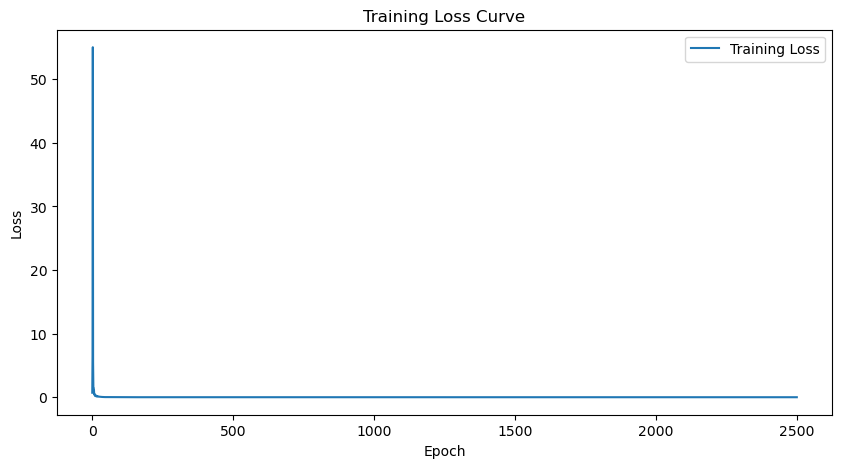

Final Model Accuracy: 73.51%
Final Model F1-score: 0.7747


In [10]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [11]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [12]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       160
non_infringement       0.70      0.87      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.75      0.74      0.73       336



/tmp/ipykernel_2791045/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
